<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/01_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***30% of Complete Portfolio***
The goal is to select the top 10 most popular stocks on news and selecting a strategy ***(based on sentiment analysis and technical indicators)*** while adhering to these following constraints:

### Step 1: Import Libraries

In [1]:
# UDFs
from py.utils import load_and_filter_data, suppress_output

# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting library
import bt

In [2]:
import logging
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress yfinance progress bars
os.environ['YFINANCE_PROGRESS'] = 'False'

# Create logger instance
logger = logging.getLogger(__name__)

logging.getLogger('bt').disabled = True
logging.getLogger('yfinance').disabled = True

# Alternative: Set logging level to critical
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

### Step 2: Define Parameters

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=1*365)            # 1 year before the end date

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2024-05-30 to 2025-05-30
Time span: 365 days (1.00 years)


#### Risk-free rate (T-bill, %)

In [4]:
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.042249999999999996 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [5]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-05-30.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [6]:
from py.fetch_fmp_api import create_session, fetch_data
from dotenv import load_dotenv
load_dotenv()

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

# Configuration variables for fetch_data function
DAYS_BACK = 7                    # Number of days to look back for news
MAX_PAGES = 10                   # Maximum number of pages to fetch
RECORDS_PER_PAGE = 1000          # Number of records per page
REQUEST_TIMEOUT = 10             # Timeout for API requests in seconds
API_BASE_URL = "https://financialmodelingprep.com/api/v3/stock_news"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"  # Date format for parsing publishedDate

# Create session and fetch data with all required parameters
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # Custom: 30 days back
    max_pages=15,           # Custom: 15 pages
    records_per_page=1000,  
    request_timeout=10      
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head(10))

Fetching page 1/15...


Page 1: 1000 articles fetched
Fetching page 2/15...
Page 2: 1000 articles fetched
Fetching page 3/15...
Page 3: 999 articles fetched
Fetching page 4/15...
Page 4: 1000 articles fetched
Fetching page 5/15...
Page 5: 998 articles fetched
Fetching page 6/15...
Page 6: 998 articles fetched
Fetching page 7/15...
Page 7: 1000 articles fetched
Fetching page 8/15...
Page 8: 1000 articles fetched
Fetching page 9/15...
Page 9: 1000 articles fetched
Fetching page 10/15...
Page 10: 1000 articles fetched
Fetching page 11/15...
Page 11: 998 articles fetched
Fetching page 12/15...
Page 12: 999 articles fetched
Fetching page 13/15...
Page 13: 1000 articles fetched
Fetching page 14/15...
Page 14: 1000 articles fetched
Fetching page 15/15...
Page 15: 999 articles fetched
Total articles fetched: 14991


shape: (10, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ symbol ‚îÜ publishedDat ‚îÜ title        ‚îÜ image        ‚îÜ site         ‚îÜ text         ‚îÜ url          ‚îÇ
‚îÇ ---    ‚îÜ e            ‚îÜ ---          ‚îÜ ---          ‚îÜ ---          ‚îÜ ---          ‚îÜ ---          ‚îÇ
‚îÇ str    ‚îÜ ---          ‚îÜ str          ‚îÜ str          ‚îÜ str          ‚îÜ str          ‚îÜ str          ‚îÇ
‚îÇ        ‚îÜ str          ‚îÜ              ‚îÜ              ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ LPRO   ‚îÜ 2025-06-01   ‚îÜ Investors in ‚îÜ https://imag ‚îÜ accessnewswi ‚îÜ NEW YORK, NY ‚îÜ https://www. ‚îÇ
‚îÇ        ‚îÜ 09:50:00     ‚îÜ Open Lending ‚îÜ es.financial ‚îÜ re.com       ‚îÜ / ACCESS     ‚îÜ accessnewswi ‚îÇ
‚îÇ        ‚îÜ              ‚îÜ Corp‚Ä¶        ‚îÜ modeli‚Ä¶      ‚îÜ              ‚îÜ Newswire‚Ä¶    ‚îÜ re.com‚Ä¶      ‚îÇ
‚îÇ MPLX   ‚îÜ 2025-06-01   ‚îÜ Change Of    ‚îÜ https://imag ‚îÜ seekingalpha ‚îÜ MPLX's new   ‚îÜ https://seek ‚îÇ
‚îÇ        ‚îÜ 09:49:31     ‚îÜ Distribution ‚îÜ es.financial ‚îÜ .com         ‚îÜ CEO shifted  ‚îÜ ingalpha.com ‚îÇ
‚îÇ        ‚îÜ              ‚îÜ Scenery‚Ä¶     ‚îÜ modeli‚Ä¶      ‚îÜ              ‚îÜ messagi‚Ä¶     ‚îÜ /artic‚Ä¶      ‚îÇ
‚îÇ IOVA   ‚îÜ 2025-06-01   ‚îÜ Lost Money   ‚îÜ https://imag ‚îÜ accessnewswi ‚îÜ NEW YORK, NY ‚îÜ https://www. ‚îÇ
‚îÇ        ‚îÜ 09:45:00     ‚îÜ on Iovance   ‚îÜ es.financial ‚îÜ re.com       ‚îÜ / ACCESS     ‚îÜ accessnewswi ‚îÇ
‚îÇ        ‚îÜ              ‚îÜ Biothera‚Ä¶    ‚îÜ modeli‚Ä¶      ‚îÜ              ‚îÜ Newswire‚Ä¶    ‚îÜ re.com‚Ä¶      ‚îÇ
‚îÇ TMCI   ‚îÜ 2025-06-01   ‚îÜ Did You Lose ‚îÜ https://imag ‚îÜ accessnewswi ‚îÜ NEW YORK, NY ‚îÜ https://www. ‚îÇ
‚îÇ        ‚îÜ 09:45:00     ‚îÜ Money on     ‚îÜ es.financial ‚îÜ re.com       ‚îÜ / ACCESS     ‚îÜ accessnewswi ‚îÇ
‚îÇ        ‚îÜ              ‚îÜ Treace M‚Ä¶    ‚îÜ modeli‚Ä¶      ‚îÜ              ‚îÜ Newswire‚Ä¶    ‚îÜ re.com‚Ä¶      ‚îÇ
‚îÇ URGN   ‚îÜ 2025-06-01   ‚îÜ July 28,     ‚îÜ https://imag ‚îÜ accessnewswi ‚îÜ NEW YORK, NY ‚îÜ https://www. ‚îÇ
‚îÇ        ‚îÜ 09:45:00     ‚îÜ 2025         ‚îÜ es.financial ‚îÜ re.com       ‚îÜ / ACCESS     ‚îÜ accessnewswi ‚îÇ
‚îÇ        ‚îÜ              ‚îÜ Deadline     ‚îÜ modeli‚Ä¶      ‚îÜ              ‚îÜ Newswire‚Ä¶    ‚îÜ re.com‚Ä¶      ‚îÇ
‚îÇ        ‚îÜ              ‚îÜ Approac‚Ä¶     ‚îÜ              ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ CGC    ‚îÜ 2025-06-01   ‚îÜ Levi &       ‚îÜ https://imag ‚îÜ accessnewswi ‚îÜ NEW YORK, NY ‚îÜ https://www. ‚îÇ
‚îÇ        ‚îÜ 09:45:00     ‚îÜ Korsinsky    ‚îÜ es.financial ‚îÜ re.com       ‚îÜ / ACCESS     ‚îÜ accessnewswi ‚îÇ
‚îÇ        ‚îÜ              ‚îÜ Urges Canopy ‚îÜ modeli‚Ä¶      ‚îÜ              ‚îÜ Newswire‚Ä¶    ‚îÜ re.com‚Ä¶      ‚îÇ
‚îÇ        ‚îÜ              ‚îÜ ‚Ä¶            ‚îÜ              ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ VTRS   ‚îÜ 2025-06-01   ‚îÜ Class Action ‚îÜ https://imag ‚îÜ accessnewswi ‚îÜ NEW YORK, NY ‚îÜ https://www. ‚îÇ
‚îÇ        ‚îÜ 09:45:00     ‚îÜ Lawsuit      ‚îÜ es.financial ‚îÜ re.com       ‚îÜ / ACCESS     ‚îÜ accessnewswi ‚îÇ
‚îÇ        ‚îÜ              ‚îÜ Filed Aga‚Ä¶   ‚îÜ modeli‚Ä¶      ‚îÜ              ‚îÜ Newswire‚Ä¶    ‚îÜ re.com‚Ä¶      ‚îÇ
‚îÇ WST    ‚îÜ 2025-06-01   ‚îÜ Join Class   ‚îÜ https://imag ‚îÜ accessnewswi ‚îÜ NEW YORK, NY ‚îÜ https://www. ‚îÇ
‚îÇ        ‚îÜ 09:45:00     ‚îÜ Action to    ‚îÜ es

### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.


In [7]:
from py.sentiment_analysis import calculate_stock_sentiment_metrics, get_fundamental_value, calculate_sector_averages

# Load fundamental data and prepare ticker lists
print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')
all_tickers = set(news_df['symbol'].to_list() + fundamentals_df['Ticker'].to_list())
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

print(f"Loaded {len(fundamentals_df)} stocks, {len(all_tickers)} unique tickers")

# Execute sentiment analysis
print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(news_df, all_tickers, EXCLUDED_SYMBOLS)
sentiment_df = pl.DataFrame([{
    "symbol": symbol, "articlesInLastWeek": metrics["articlesInLastWeek"],
    "companyNewsScore": metrics["companyNewsScore"], 
    "bearishPercent": metrics["sentiment"]["bearishPercent"],
    "bullishPercent": metrics["sentiment"]["bullishPercent"],
    "averageSentimentScore": metrics["averageSentimentScore"],
    "totalArticles": metrics["totalArticles"]
} for symbol, metrics in sentiment_metrics.items()]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

print(f"Sentiment analysis completed for {len(sentiment_df)} stocks")
display(sentiment_df.head(10))

# Add fundamental data and sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
sentiment_with_fundamentals = sentiment_df.with_columns([
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0), return_dtype=pl.Float64).alias("sectorAverageBullishPercent"),
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0), return_dtype=pl.Float64).alias("sectorAverageNewsScore"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

# Screen stocks and analyze sectors
comprehensive_screened = sentiment_with_fundamentals.filter((pl.col("articlesInLastWeek") >= 3) & (pl.col("companyNewsScore") >= 0.45)).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])
sector_summary = sentiment_with_fundamentals.filter(pl.col("sector") != "Unknown").group_by("sector").agg([
    pl.count("symbol").alias("stock_count"), pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"), pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"), pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print(f"\nScreened {len(comprehensive_screened)} stocks, {len(sector_averages)} sectors")
display(comprehensive_screened.head(15))
display(sector_summary)

# Export results
# sentiment_with_fundamentals.write_csv("data/combined_sentiment_fundamentals.csv")
# comprehensive_screened.write_csv("data/screened_stocks.csv")
# print("Files saved: combined_sentiment_fundamentals.csv and screened_stocks.csv")

Loading fundamental data...
Loaded 504 stocks, 4296 unique tickers
Analyzing sentiment for stock symbols...
Sentiment analysis completed for 3531 stocks


shape: (10, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ symbol ‚îÜ articlesInLa ‚îÜ companyNewsS ‚îÜ bearishPerce ‚îÜ bullishPerce ‚îÜ averageSenti ‚îÜ totalArticle ‚îÇ
‚îÇ ---    ‚îÜ stWeek       ‚îÜ core         ‚îÜ nt           ‚îÜ nt           ‚îÜ mentScore    ‚îÜ s            ‚îÇ
‚îÇ str    ‚îÜ ---          ‚îÜ ---          ‚îÜ ---          ‚îÜ ---          ‚îÜ ---          ‚îÜ ---          ‚îÇ
‚îÇ        ‚îÜ i64          ‚îÜ f64          ‚îÜ f64          ‚îÜ f64          ‚îÜ f64          ‚îÜ i64          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ SAN    ‚îÜ 317          ‚îÜ 0.5376       ‚îÜ 0.0536       ‚îÜ 0.3344       ‚îÜ 0.0752       ‚îÜ 317          ‚îÇ
‚îÇ VTRS   ‚îÜ 256          ‚îÜ 0.5603       ‚îÜ 0.0195       ‚îÜ 0.5742       ‚îÜ 0.1207       ‚îÜ 256          ‚îÇ
‚îÇ IOVA   ‚îÜ 256          ‚îÜ 0.5547       ‚îÜ 0.0234       ‚îÜ 0.5273       ‚îÜ 0.1094       ‚îÜ 256          ‚îÇ
‚îÇ OTC    ‚îÜ 242          ‚îÜ 0.56         ‚îÜ 0.0413       ‚îÜ 0.5537       ‚îÜ 0.12         ‚îÜ 242          ‚îÇ
‚îÇ D      ‚îÜ 242          ‚îÜ 0.5573       ‚îÜ 0.0496       ‚îÜ 0.4959       ‚îÜ 0.1146       ‚îÜ 242          ‚îÇ
‚îÇ AM     ‚îÜ 240          ‚îÜ 0.6445       ‚îÜ 0.0042       ‚îÜ 0.8          ‚îÜ 0.2891       ‚îÜ 240          ‚îÇ
‚îÇ CIVI   ‚îÜ 232          ‚îÜ 0.5633       ‚îÜ 0.0172       ‚îÜ 0.625        ‚îÜ 0.1266       ‚îÜ 232          ‚îÇ
‚îÇ NET    ‚îÜ 227          ‚îÜ 0.5388       ‚îÜ 0.0          ‚îÜ 0.4714       ‚îÜ 0.0777       ‚îÜ 227          ‚îÇ
‚îÇ NVDA   ‚îÜ 225          ‚îÜ 0.5469       ‚îÜ 0.0844       ‚îÜ 0.4311       ‚îÜ 0.0938       ‚îÜ 225          ‚îÇ
‚îÇ V      ‚îÜ 221          ‚îÜ 0.5435       ‚îÜ 0.0317       ‚îÜ 0.3484       ‚îÜ 0.087        ‚îÜ 221          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


Screened 1709 stocks, 11 sectors


shape: (15, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ symbol ‚îÜ articlesInLa ‚îÜ companyNewsS ‚îÜ bearishPerce ‚îÜ ‚Ä¶ ‚îÜ sector   ‚îÜ marketCap ‚îÜ peRatio ‚îÜ price ‚îÇ
‚îÇ ---    ‚îÜ stWeek       ‚îÜ core         ‚îÜ nt           ‚îÜ   ‚îÜ ---      ‚îÜ ---       ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str    ‚îÜ ---          ‚îÜ ---          ‚îÜ ---          ‚îÜ   ‚îÜ str      ‚îÜ f64       ‚îÜ f64     ‚îÜ f64   ‚îÇ
‚îÇ        ‚îÜ i64          ‚îÜ f64          ‚îÜ f64          ‚îÜ   ‚îÜ          ‚îÜ           ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ BGM    ‚îÜ 4            ‚îÜ 0.9          ‚îÜ 0.0          ‚îÜ ‚Ä¶ ‚îÜ Unknown  ‚îÜ 0.0       ‚îÜ 0.0     ‚îÜ 0.0   ‚îÇ
‚îÇ LPCN   ‚îÜ 4            ‚îÜ 0.8          ‚îÜ 0.0          ‚îÜ ‚Ä¶ ‚îÜ Unknown  ‚îÜ 0.0       ‚îÜ 0.0     ‚îÜ 0.0   ‚îÇ
‚îÇ NSCIF  ‚îÜ 3            ‚îÜ 0.7803       ‚îÜ 0.0          ‚îÜ ‚Ä¶ ‚îÜ Unknown  ‚îÜ 0.0       ‚îÜ 0.0     ‚îÜ 0.0   ‚îÇ
‚îÇ BBY    ‚îÜ 24           ‚îÜ 0.7785       ‚îÜ 0.0          ‚îÜ ‚Ä¶ ‚îÜ Consumer ‚îÜ 1.3848e10 ‚îÜ 15.29   ‚îÜ 65.42 ‚îÇ
‚îÇ        ‚îÜ              ‚îÜ              ‚îÜ              ‚îÜ   ‚îÜ Cyclical ‚îÜ           ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ AGS    ‚îÜ 3            ‚îÜ 0.775        ‚îÜ 0.0          ‚îÜ ‚Ä¶ ‚îÜ Unknown  ‚îÜ 0.0       ‚îÜ 0.0     ‚îÜ 0.0   ‚îÇ
‚îÇ ‚Ä¶      ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ FWONK  ‚îÜ 3            ‚îÜ 0.75         ‚îÜ 0.0          ‚îÜ ‚Ä¶ ‚îÜ Unknown  ‚îÜ 0.0       ‚îÜ 0.0     ‚îÜ 0.0   ‚îÇ
‚îÇ MGMNF  ‚îÜ 4            ‚îÜ 0.748        ‚îÜ 0.0          ‚îÜ ‚Ä¶ ‚îÜ Unknown  ‚îÜ 0.0       ‚îÜ 0.0     ‚îÜ 0.0   ‚îÇ
‚îÇ SSRM   ‚îÜ 3            ‚îÜ 0.7456       ‚îÜ 0.0          ‚îÜ ‚Ä¶ ‚îÜ Unknown  ‚îÜ 0.0       ‚îÜ 0.0     ‚îÜ 0.0   ‚îÇ
‚îÇ HNI    ‚îÜ 8            ‚îÜ 0.7406       ‚îÜ 0.0          ‚îÜ ‚Ä¶ ‚îÜ Unknown  ‚îÜ 0.0       ‚îÜ 0.0     ‚îÜ 0.0   ‚îÇ
‚îÇ GRND   ‚îÜ 3            ‚îÜ 0.7391       ‚îÜ 0.0          ‚îÜ ‚Ä¶ ‚îÜ Unknown  ‚îÜ 0.0       ‚îÜ 0.0     ‚îÜ 0.0   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

shape: (11, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ sector       ‚îÜ stock_count ‚îÜ avg_news_sc ‚îÜ avg_bullish ‚îÜ avg_article ‚îÜ avg_market_ ‚îÜ avg_pe_rati ‚îÇ
‚îÇ ---          ‚îÜ ---         ‚îÜ ore         ‚îÜ _percent    ‚îÜ s           ‚îÜ cap         ‚îÜ o           ‚îÇ
‚îÇ str          ‚îÜ u32         ‚îÜ ---         ‚îÜ ---         ‚îÜ ---         ‚îÜ ---         ‚îÜ ---         ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ f64         ‚îÜ f64         ‚îÜ f64         ‚îÜ f64         ‚îÜ f64         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Utilities    ‚îÜ 28          ‚îÜ 0.59405     ‚îÜ 0.603164    ‚îÜ 17.214286   ‚îÜ 4.2423e10   ‚îÜ 20.590714   ‚îÇ
‚îÇ Communicatio ‚îÜ 19          ‚îÜ 0.577263    ‚îÜ 0.534163    ‚îÜ 26.421053   ‚îÜ 3.9629e11   ‚îÜ NaN         ‚îÇ
‚îÇ n Services   ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Healthcare   ‚îÜ 51          ‚îÜ 0.574551    ‚îÜ 0.546006    ‚îÜ 20.352941   ‚îÜ 9.1028e10   ‚îÜ NaN         ‚îÇ
‚îÇ Technology   ‚îÜ 77          ‚îÜ 0.571757    ‚îÜ 0.524968    ‚îÜ 16.545455   ‚îÜ 2.1723e11   ‚îÜ NaN         ‚îÇ
‚îÇ Consumer     ‚îÜ 50          ‚îÜ 0.568762    ‚îÜ 0.507468    ‚îÜ 13.3        ‚îÜ 1.1792e11   ‚îÜ NaN         ‚îÇ
‚îÇ Cyclical     ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ ‚Ä¶            ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶           ‚îÇ
‚îÇ Consumer     ‚îÜ 32          ‚îÜ 0.560516    ‚îÜ 0.497478    ‚îÜ 14.9375     ‚îÜ 1.0255e11   ‚îÜ NaN         ‚îÇ
‚îÇ Defensive    ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Energy       ‚îÜ 21          ‚îÜ 0.556838    ‚îÜ 0.382505    ‚îÜ 6.095238    ‚îÜ 7.0078e10   ‚îÜ NaN         ‚îÇ
‚îÇ Real Estate  ‚îÜ 29          ‚îÜ 0.554121    ‚îÜ 0.423997    ‚îÜ 8.62069     ‚îÜ 3.6148e10   ‚îÜ NaN         ‚îÇ
‚îÇ Financial    ‚îÜ 57          ‚îÜ 0.552082    ‚îÜ 0.392288    ‚îÜ 12.017544   ‚îÜ 1.0500e11   ‚îÜ NaN         ‚îÇ
‚îÇ Services     ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Basic        ‚îÜ 17          ‚îÜ 0.533253    ‚îÜ 0.355365    ‚îÜ 5.941176    ‚îÜ 3.6470e10   ‚îÜ NaN         ‚îÇ
‚îÇ Materials    ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Step 5: Select 10 stocks by sentiment score (bullish and bearish)
- Constrained by being part of the s&p 500 index and not already in the portfolio long-term portfolio.

In [8]:
# Load long-term portfolio and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term_portfolio')['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks with highest sentiment scores")
display(selected_stocks.head(10))

# Sector distribution and summary statistics
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution:")
display(sector_distribution)

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of stocks: {selected_stocks['symbol'].count()}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 5 tickers already in long-term portfolio: ['PH', 'TMUS', 'MMC', 'GS', 'SO']

Selected 100 stocks with highest sentiment scores


shape: (10, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ symbol ‚îÜ articlesInL ‚îÜ companyNews ‚îÜ bearishPerc ‚îÜ ‚Ä¶ ‚îÜ sector     ‚îÜ marketCap ‚îÜ peRatio ‚îÜ price  ‚îÇ
‚îÇ ---    ‚îÜ astWeek     ‚îÜ Score       ‚îÜ ent         ‚îÜ   ‚îÜ ---        ‚îÜ ---       ‚îÜ ---     ‚îÜ ---    ‚îÇ
‚îÇ str    ‚îÜ ---         ‚îÜ ---         ‚îÜ ---         ‚îÜ   ‚îÜ str        ‚îÜ f64       ‚îÜ f64     ‚îÜ f64    ‚îÇ
‚îÇ        ‚îÜ i64         ‚îÜ f64         ‚îÜ f64         ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ         ‚îÜ        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ BBY    ‚îÜ 24          ‚îÜ 0.7785      ‚îÜ 0.0         ‚îÜ ‚Ä¶ ‚îÜ Consumer   ‚îÜ 1.3848e10 ‚îÜ 15.29   ‚îÜ 65.42  ‚îÇ
‚îÇ        ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ   ‚îÜ Cyclical   ‚îÜ           ‚îÜ         ‚îÜ        ‚îÇ
‚îÇ ATO    ‚îÜ 6           ‚îÜ 0.7327      ‚îÜ 0.0         ‚îÜ ‚Ä¶ ‚îÜ Utilities  ‚îÜ 2.4434e10 ‚îÜ 21.48   ‚îÜ 153.83 ‚îÇ
‚îÇ FI     ‚îÜ 4           ‚îÜ 0.7242      ‚îÜ 0.0         ‚îÜ ‚Ä¶ ‚îÜ Technology ‚îÜ 8.8477e10 ‚îÜ 28.29   ‚îÜ 159.58 ‚îÇ
‚îÇ CHTR   ‚îÜ 5           ‚îÜ 0.71        ‚îÜ 0.0         ‚îÜ ‚Ä¶ ‚îÜ Communicat ‚îÜ 5.5588e10 ‚îÜ 11.23   ‚îÜ 402.42 ‚îÇ
‚îÇ        ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ   ‚îÜ ion        ‚îÜ           ‚îÜ         ‚îÜ        ‚îÇ
‚îÇ        ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ   ‚îÜ Services   ‚îÜ           ‚îÜ         ‚îÜ        ‚îÇ
‚îÇ NXPI   ‚îÜ 4           ‚îÜ 0.7         ‚îÜ 0.0         ‚îÜ ‚Ä¶ ‚îÜ Technology ‚îÜ 4.9566e10 ‚îÜ 21.37   ‚îÜ 196.2  ‚îÇ
‚îÇ GIS    ‚îÜ 4           ‚îÜ 0.6687      ‚îÜ 0.0         ‚îÜ ‚Ä¶ ‚îÜ Consumer   ‚îÜ 2.9425e10 ‚îÜ 11.81   ‚îÜ 53.74  ‚îÇ
‚îÇ        ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ   ‚îÜ Defensive  ‚îÜ           ‚îÜ         ‚îÜ        ‚îÇ
‚îÇ FIS    ‚îÜ 6           ‚îÜ 0.6643      ‚îÜ 0.0         ‚îÜ ‚Ä¶ ‚îÜ Technology ‚îÜ 4.1112e10 ‚îÜ 49.84   ‚îÜ 78.25  ‚îÇ
‚îÇ DTE    ‚îÜ 18          ‚îÜ 0.6614      ‚îÜ 0.0         ‚îÜ ‚Ä¶ ‚îÜ Utilities  ‚îÜ 2.8088e10 ‚îÜ 18.29   ‚îÜ 135.35 ‚îÇ
‚îÇ XOM    ‚îÜ 11          ‚îÜ 0.661       ‚îÜ 0.0         ‚îÜ ‚Ä¶ ‚îÜ Energy     ‚îÜ 4.3898e11 ‚îÜ 13.51   ‚îÜ 101.86 ‚îÇ
‚îÇ IR     ‚îÜ 77          ‚îÜ 0.6604      ‚îÜ 0.0         ‚îÜ ‚Ä¶ ‚îÜ Industrial ‚îÜ 3.2951e10 ‚îÜ 40.43   ‚îÜ 81.67  ‚îÇ
‚îÇ        ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ   ‚îÜ s          ‚îÜ           ‚îÜ         ‚îÜ        ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


Sector distribution:


shape: (11, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ sector             ‚îÜ stock_count ‚îÜ avg_sentiment_score ‚îÜ avg_news_score ‚îÜ avg_bullish_percent ‚îÇ
‚îÇ ---                ‚îÜ ---         ‚îÜ ---                 ‚îÜ ---            ‚îÜ ---                 ‚îÇ
‚îÇ str                ‚îÜ u32         ‚îÜ f64                 ‚îÜ f64            ‚îÜ f64                 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Technology         ‚îÜ 21          ‚îÜ 0.251781            ‚îÜ 0.625914       ‚îÜ 0.703086            ‚îÇ
‚îÇ Industrials        ‚îÜ 16          ‚îÜ 0.240075            ‚îÜ 0.620056       ‚îÜ 0.724181            ‚îÇ
‚îÇ Utilities          ‚îÜ 13          ‚îÜ 0.266954            ‚îÜ 0.633477       ‚îÜ 0.714285            ‚îÇ
‚îÇ Healthcare         ‚îÜ 12          ‚îÜ 0.216025            ‚îÜ 0.608008       ‚îÜ 0.739217            ‚îÇ
‚îÇ Consumer Cyclical  ‚îÜ 11          ‚îÜ 0.262482            ‚îÜ 0.631227       ‚îÜ 0.679009            ‚îÇ
‚îÇ ‚Ä¶                  ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶                   ‚îÜ ‚Ä¶              ‚îÜ ‚Ä¶                   ‚îÇ
‚îÇ Financial Services ‚îÜ 5           ‚îÜ 0.24698             ‚îÜ 0.62348        ‚îÜ 0.79696             ‚îÇ
‚îÇ Communication      ‚îÜ 5           ‚îÜ 0.29262             ‚îÜ 0.6463         ‚îÜ 0.62192             ‚îÇ
‚îÇ Services           ‚îÜ             ‚îÜ                     ‚îÜ                ‚îÜ                     ‚îÇ
‚îÇ Energy             ‚îÜ 5           ‚îÜ 0.25732             ‚îÜ 0.62864        ‚îÜ 0.71656             ‚îÇ
‚îÇ Basic Materials    ‚îÜ 3           ‚îÜ 0.2224              ‚îÜ 0.611167       ‚îÜ 0.7549              ‚îÇ
‚îÇ Real Estate        ‚îÜ 2           ‚îÜ 0.26295             ‚îÜ 0.63145        ‚îÜ 0.63335             ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


Summary statistics for selected stocks:
Average sentiment score: 0.2479
Min sentiment score: 0.1757
Max sentiment score: 0.5571
Average company news score: 0.6239
Number of stocks: 100
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [9]:
from py.utils import suppress_output

quotes = suppress_output(bt.get, screened_tickers, start=start_date, end=end_date)
display(quotes.head(10))

bby         ato          fi        chtr        nxpi  \
Date                                                                    
2024-05-30  78.123245  109.988556  147.880005  276.109985  266.736328   
2024-05-31  81.255836  113.241608  149.759995  287.119995  267.394806   
2024-06-03  83.286743  112.841080  148.470001  286.220001  265.272125   
2024-06-04  84.158501  113.212303  147.990005  280.600006  261.695099   
2024-06-05  85.202705  112.352638  149.309998  278.100006  270.932526   
2024-06-06  84.455490  112.782471  150.559998  279.359985  267.306335   
2024-06-07  84.225571  112.127945  151.419998  276.829987  267.188416   
2024-06-10  83.487930  112.811775  149.600006  276.070007  272.062653   
2024-06-11  83.449608  113.075539  148.000000  276.829987  273.123962   
2024-06-12  82.750275  113.495605  148.020004  275.059998  278.096466   

                  gis        fis         dte         xom         ir  ...  \
Date                                                                 ...   
2024-05-30  64.148483  72.693764  108.938644  110.149170  91.917480  ...   
2024-05-31  66.169662  74.460083  112.590881  113.308990  92.966545  ...   
2024-06-03  65.207199  74.617081  112.310669  110.593674  89.959244  ...   
2024-06-04  65.582550  74.646523  112.590881  108.873642  87.881111  ...   
2024-06-05  64.928078  74.538582  110.668144  109.308487  89.649529  ...   
2024-06-06  64.860703  74.940926  109.701942  110.129852  88.300728  ...   
2024-06-07  64.928078  76.059578  108.532852  108.950958  89.050049  ...   
2024-06-10  64.389107  76.197609  108.832367  109.269836  91.108215  ...   
2024-06-11  64.466103  74.758240  109.895180  108.390503  91.298042  ...   
2024-06-12  62.839527  75.862404  108.822701  107.192284  94.655022  ...   

                  intu         fe        dltr         ceg        ulta  \
Date                                                                    
2024-05-30  559.341125  37.408058  114.790001  223.465958  385.579987   
2024-05-31  572.724304  38.626530  117.949997  215.807175  395.089996   
2024-06-03  563.563721  38.540180  120.980003  206.876862  389.910004   
2024-06-04  568.372559  38.578560  120.300003  201.790878  389.410004   
2024-06-05  570.568298  37.839798  114.379997  207.939774  387.160004   
2024-06-06  568.958679  37.513592  112.370003  201.254471  384.880005   
2024-06-07  570.200623  37.244957  111.290001  196.685013  382.609985   
2024-06-10  563.583557  37.350491  110.190002  213.204559  382.500000   
2024-06-11  563.047119  37.244957  109.639999  216.860123  387.690002   
2024-06-12  588.402588  37.081852  108.870003  216.681320  390.119995   

                   jnj        apa         ko          dg         ew  
Date                                                                 
2024-05-30  140.695847  28.429995  60.170387  124.680206  87.889999  
2024-05-31  142.041992  29.195013  61.102512  133.421661  86.889999  
2024-06-03  143.078232  28.152678  61.102512  136.004135  87.860001  
2024-06-04  143.136337  27.693665  62.083176  131.082809  87.410004  
2024-06-05  141.364075  27.731918  62.063755  130.995087  87.070000  
2024-06-06  141.799881  27.951859  62.287083  126.229698  87.680000  
2024-06-07  142.439056  27.588476  62.054050  123.384094  88.139999  
2024-06-10  142.487488  28.181364  61.743347  124.436569  86.099998  
2024-06-11  142.129150  28.391745  61.704502  123.540016  87.000000  
2024-06-12  140.821747  28.047485  61.053963  121.746902  87.769997  

[10 rows x 100 columns]

### Step 7: Create Trading Signals
- Use `talib` library to create signals.

In [10]:
from py.technical_analysis import calculate_technical_indicators, generate_trading_signals

# Execute technical analysis
technical_indicators = calculate_technical_indicators(quotes)
trading_signals = generate_trading_signals(technical_indicators)
available_tickers = list(technical_indicators.keys())

# Display sample results for first ticker
sample_ticker = available_tickers[0]
print(f"\nSample indicators and signals for {sample_ticker}:")
display(technical_indicators[sample_ticker].tail(5))

Calculating indicators for bby...
Calculating indicators for ato...
Calculating indicators for fi...
Calculating indicators for chtr...
Calculating indicators for nxpi...
Calculating indicators for gis...
Calculating indicators for fis...
Calculating indicators for dte...
Calculating indicators for xom...
Calculating indicators for ir...
Calculating indicators for nvr...
Calculating indicators for mpc...
Calculating indicators for ual...
Calculating indicators for wec...
Calculating indicators for has...
Calculating indicators for kkr...
Calculating indicators for frt...
Calculating indicators for peg...
Calculating indicators for trmb...
Calculating indicators for dis...
Calculating indicators for duk...
Calculating indicators for ndaq...
Calculating indicators for lhx...
Calculating indicators for gev...
Calculating indicators for exc...
Calculating indicators for cnc...
Calculating indicators for wbd...
Calculating indicators for vz...
Calculating indicators for gen...
Calculating i

Close   SMA_20     SMA_50    SMA_200     EMA_12     EMA_26  \
Date                                                                         
2025-05-23  69.919998  69.8850  68.353316  82.888460  70.671606  69.689109   
2025-05-27  72.220001  70.1220  68.385867  82.859095  70.909820  69.876582   
2025-05-28  71.519997  70.3640  68.359390  82.817231  71.003694  69.998316   
2025-05-29  66.320000  70.3455  68.241552  82.743705  70.283125  69.725849   
2025-05-30  66.279999  70.3075  68.109880  82.682221  69.667260  69.470600   

               EMA_50        ADX    PLUS_DI   MINUS_DI     RSI_14     RSI_21  
Date                                                                          
2025-05-23  70.661822  13.754470  50.782719  49.217281  50.782719  49.738551  
2025-05-27  70.722928  13.779281  57.050909  42.949091  57.050909  53.703091  
2025-05-28  70.754185  13.475742  54.764869  45.235131  54.764869  52.382686  
2025-05-29  70.580296  13.731621  41.470973  58.529027  41.470973  43.953380  
2025-05-30  70.411656  13.981114  41.387744  58.612256  41.387744  43.896326

### Step 8: Backtest Strategies
- Use `bt` library for backtesting the strategy.

In [11]:
from py.technical_analysis import run_backtest, best_strategy_analysis

# Configuration constants
PORTFOLIO_CONFIG = {
    'min_cagr': 0.1,        # Minimum 10% CAGR
    'max_volatility': 0.3,  # Maximum 30% volatility
    'max_stocks': 10        # Maximum 10 stocks in portfolio
}

# Step 1: Run strategy backtesting
backtest_data = run_backtest(quotes, trading_signals, available_tickers)

# Step 2: Analyze best strategies and build portfolio
analysis_results = best_strategy_analysis(quotes, trading_signals, backtest_data, available_tickers, **PORTFOLIO_CONFIG)

STRATEGY BACKTESTING ANALYSIS

üîÑ Running strategy backtests...
üîÑ Running 400 backtests silently...
  Progress: 5%
  Progress: 10%
  Progress: 15%
  Progress: 20%
  Progress: 25%
  Progress: 30%
  Progress: 35%
  Progress: 40%
  Progress: 45%
  Progress: 50%
  Progress: 55%
  Progress: 60%
  Progress: 65%
  Progress: 70%
  Progress: 75%
  Progress: 80%
  Progress: 85%
  Progress: 90%
  Progress: 95%
  Progress: 100%
‚úÖ Backtesting completed

üîÑ Portfolio Construction
üìä CAGR Filtering: 100 ‚Üí 57 tickers (‚â•10.0%)
üìä Volatility Filtering: ‚Üí 39 tickers (‚â§30.0%)
üèÜ Selected top 10 performers:
  #1. cnp: 44.60% CAGR, 19.97% Vol, Sharpe: 1.96 (EMA_Cross_Signal)
  #2. gild: 42.95% CAGR, 25.17% Vol, Sharpe: 1.55 (EMA_Cross_Signal)
  #3. nvr: 37.11% CAGR, 23.07% Vol, Sharpe: 1.49 (SMA_Cross_Signal)
  #4. pm: 36.10% CAGR, 24.98% Vol, Sharpe: 1.37 (EMA_Cross_Signal)
  #5. fis: 35.83% CAGR, 25.11% Vol, Sharpe: 1.35 (SMA_Cross_Signal)
  #6. ndaq: 32.96% CAGR, 23.42% Vol, Sharpe

cagr  total_return  max_drawdown  sharpe_ratio  volatility  \
cnp   0.445980      0.447076     -0.086500      1.958108    0.199694   
gild  0.429499      0.430548     -0.178775      1.554255    0.251708   
nvr   0.371052      0.371941     -0.103269      1.492007    0.230705   
pm    0.361046      0.361908     -0.234092      1.367342    0.249787   
fis   0.358282      0.359136     -0.119635      1.349908    0.251136   
ndaq  0.329605      0.330383     -0.138756      1.340860    0.234192   
anet  0.306015      0.306731     -0.096810      1.132834    0.265629   
lmt   0.295949      0.296639     -0.132242      1.295686    0.219787   
fcx   0.287298      0.287966     -0.058374      1.472064    0.183269   
amd   0.286572      0.287238     -0.088035      1.079278    0.263510   

              strategy  
cnp   EMA_Cross_Signal  
gild  EMA_Cross_Signal  
nvr   SMA_Cross_Signal  
pm    EMA_Cross_Signal  
fis   SMA_Cross_Signal  
ndaq  EMA_Cross_Signal  
anet        RSI_Signal  
lmt   SMA_Cross_Signal  
fcx         RSI_Signal  
amd         RSI_Signal

‚úÖ Strategy Analysis Complete!

üìà Portfolio: 10 stocks
  üìä Avg CAGR: 34.71% | Avg Sharpe: 1.40 | Avg Volatility: 23.49% | Avg Drawdown: -12.36%
  üéØ Strategy Distribution:
    - EMA_Cross_Signal: 4 stocks (40.0%)
    - SMA_Cross_Signal: 3 stocks (30.0%)
    - RSI_Signal: 3 stocks (30.0%)


### Step 9: Plot the Best Strategies

üìä Generating Portfolio Charts...

üìà Portfolio Performance:


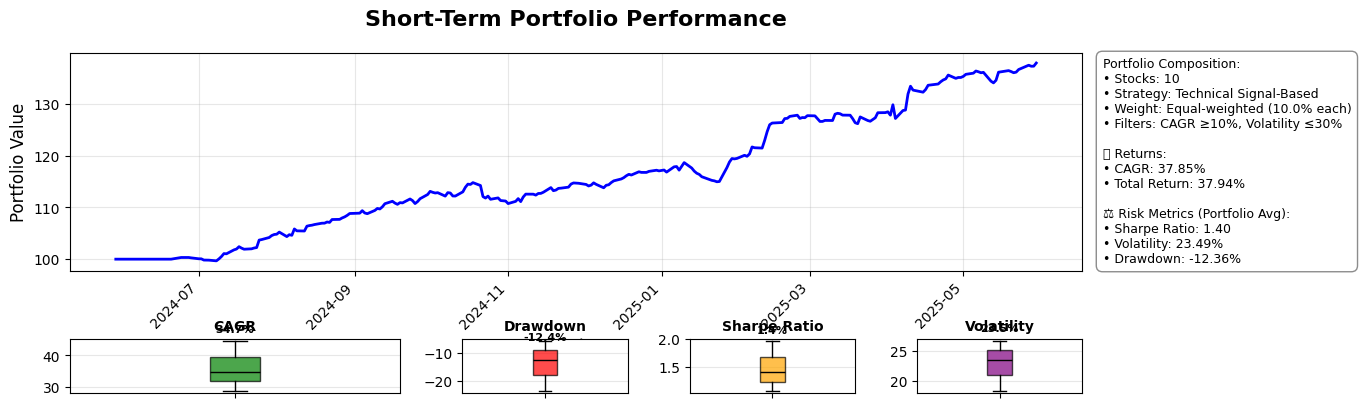


üìà Strategy Signals by Ticker:
üìã Included tickers: ['cnp', 'gild', 'nvr', 'pm', 'fis', 'ndaq', 'anet', 'lmt', 'fcx', 'amd']
üìä Plotting 10 tickers that passed the 10% CAGR and ‚â§30% volatility thresholds


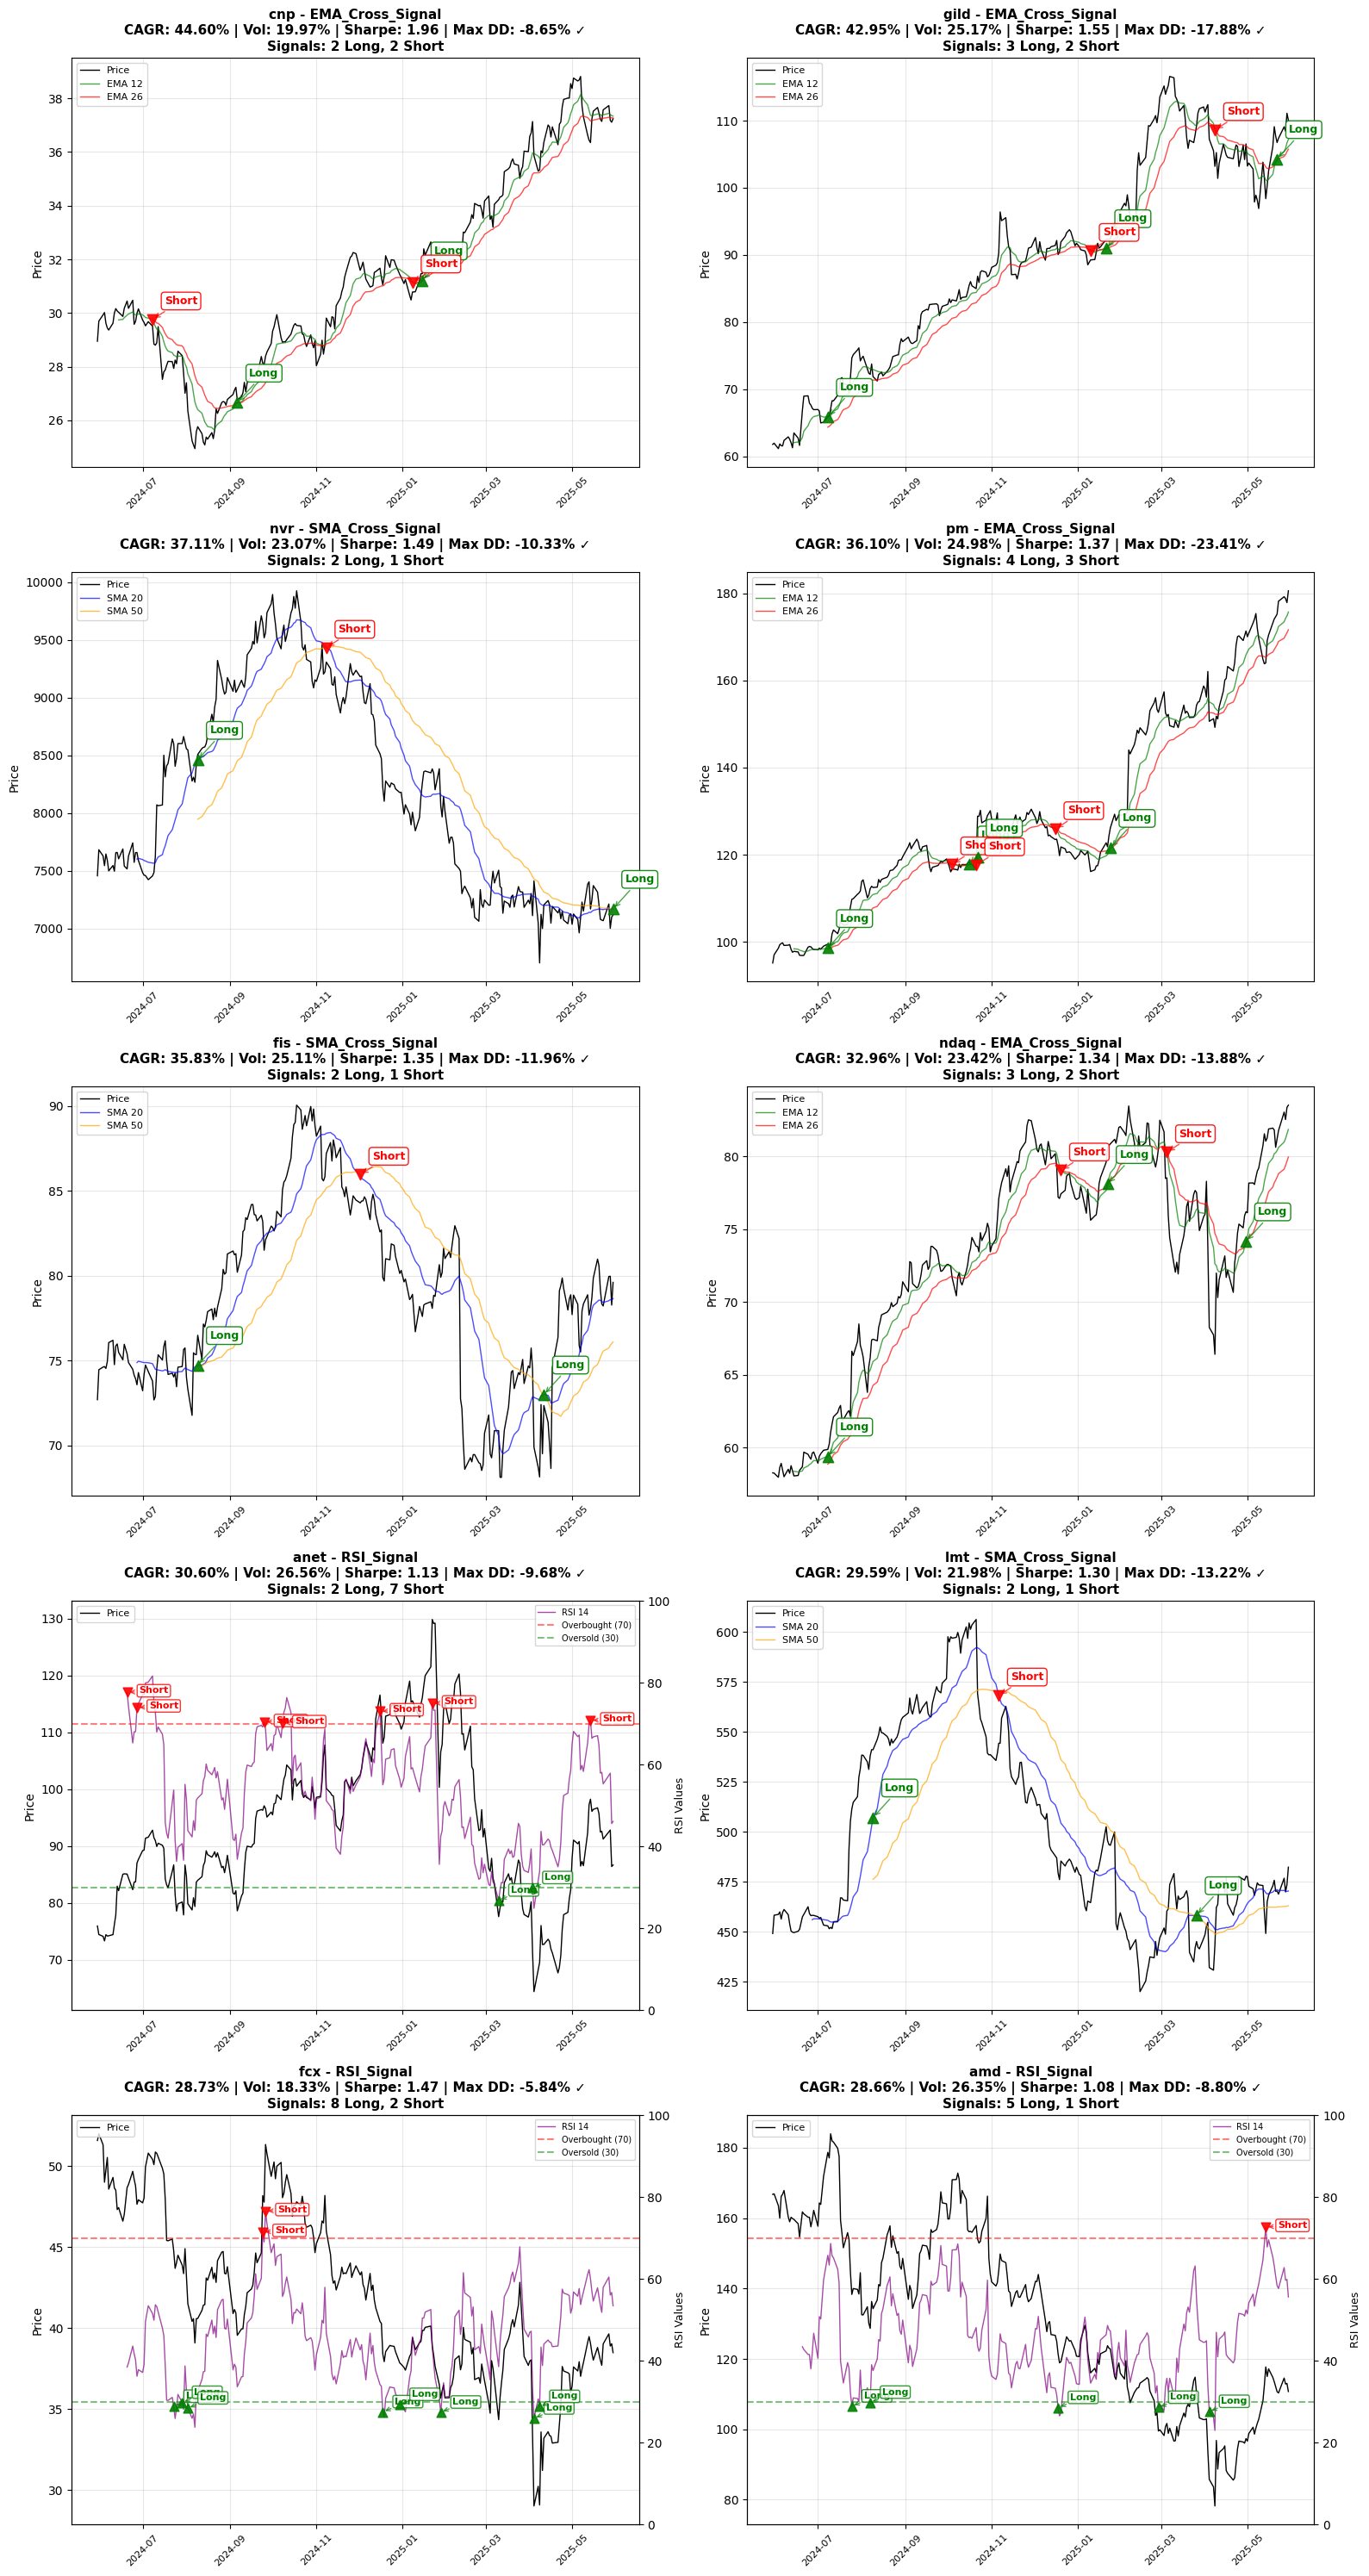


‚úÖ Chart generation complete!


In [12]:
from py.technical_analysis import plot_portfolio_performance, plot_ticker_signals_with_annotations

# Chart generation
print("üìä Generating Portfolio Charts...")

for chart_type, func in [("Portfolio Performance", lambda: plot_portfolio_performance(analysis_results)), 
                         ("Strategy Signals by Ticker", lambda: plot_ticker_signals_with_annotations(
                             quotes, trading_signals, technical_indicators, 
                             analysis_results['best_strategies'], analysis_results['included_tickers'])
                          if all([quotes is not None, trading_signals, technical_indicators,
                                 all(key in analysis_results for key in ['best_strategies', 'included_tickers']),
                                 analysis_results['included_tickers']]) 
                          else print("‚ö†Ô∏è Missing required data or no tickers passed thresholds"))]:
    try:
        print(f"\nüìà {chart_type}:")
        if chart_type == "Strategy Signals by Ticker" and analysis_results.get('included_tickers'):
            print(f"üìã Included tickers: {analysis_results['included_tickers']}")
        func()
    except Exception as e:
        print(f"Error plotting {chart_type.lower()}: {e}")

print("\n‚úÖ Chart generation complete!")

### Step 11: Plot the Portfolio Weights

In [13]:
# Calculate industry weights
industry_df = pd.DataFrame({
    'Ticker': filtered_tickers,
    'Weight': filtered_weights,
    'Sector': [fundamentals_df.loc[ticker, 'Sector'] for ticker in filtered_tickers]
})
sector_weights = industry_df.groupby('Sector')['Weight'].sum()
industries = sector_weights.index.tolist()
weights = sector_weights.values.tolist()

NameError: name 'filtered_tickers' is not defined

In [ ]:
# Plot asset allocation
plot_portfolio_weights(
    filtered_tickers, 
    filtered_weights,
    'Portfolio Weight Allocation (By Asset)', 
    'Assets',
    metrics=[
        ('Sharpe Ratio', optimal_sharpe_ratio, 4, False),
        ('Expected Return', optimal_portfolio_return, 2, True),
        ('Expected Volatility', optimal_portfolio_volatility, 2, True)
    ],
    rotation=0,
    show_constraints=True,
    max_allocation_weight=max_allocation_weight,
    max_assets=max_assets,
    max_asset_per_sector=max_asset_per_sector
)

# Plot sector allocation
plot_portfolio_weights(
    industries, 
    weights,
    'Portfolio Weight Allocation (By Sector)', 
    'Industries',
    metrics=[
        ('Sharpe Ratio', optimal_sharpe_ratio, 4, False),
        ('Expected Return', optimal_portfolio_return, 2, True),
        ('Expected Volatility', optimal_portfolio_volatility, 2, True)
    ],
    rotation=45,
    show_constraints=True,
    max_allocation_weight=max_allocation_weight,
    max_assets=max_assets,
    max_asset_per_sector=max_asset_per_sector
)

### Step 12: Export Potfolio to Excel

#### Prepare DataFrame for Export

In [ ]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = daily_prices_df[filtered_tickers].join(daily_risk_free_df, how='inner')

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime (redundant if already datetime, but safe)
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

#### Export DataFrame to Excel

In [ ]:
# Create a single Excel file with multiple sheets
with pd.ExcelWriter(output_file) as writer:
    # Each DataFrame goes to a different sheet
    optimal_portfolio_df.to_excel(writer, sheet_name='equity')

    # Export daily_quotes
    daily_prices_df_merged.to_excel(writer, sheet_name='daily_quotes')

    # Export daily_quotes
    monthly_prices_df_merged.to_excel(writer, sheet_name='monthly_quotes')

    # Export daily_quotes
    monthly_prices_df_merged.to_excel(writer, sheet_name='monthly_quotes')

    # Export risk_free
    last_risk_free_df.to_excel(writer, sheet_name='risk_free')